In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import warnings
warnings.simplefilter("ignore")

- 드라이브에 있는 train_X_df, train_y_df를 사용 -> 다음 버전으로 20231211_final의 데이터 셋을 사용해보겠습니다.

In [2]:
X_trn = pd.read_csv("/home/sangjun/work/data/train_X_231211.csv")
X_origin = X_trn.copy()
y_trn = pd.read_csv("/home/sangjun/work/data/train_y_231211.csv")
X_trn.drop("depressed", axis=1,inplace=True) # depressed가 있어서 삭제

사용할 feature

In [3]:
num_features = ['HE_chol', 'HE_Bplt', 'HE_wt', 'HE_ht', 'HE_RBC', 'HE_HDL_st2', 'HE_HB', 'age', 'HE_Uph', 'HE_crea', 'HE_Usg', 'HE_WBC', 'HE_TG', 'HE_alt', 'HE_ast',
 'HE_HCT', 'HE_dbp', 'HE_glu', 'HE_BUN', 'ainc', 'HE_sbp', 'HE_wc']
onehot_features = ['BO2_1', 'educ', 'BH1', 'EC_stt_2', 'sex', 'HE_Unitr', 'LQ4_00', 'DI1_pt', 'BM1_5', 'DE1_pt', 'DJ4_pt', 'HE_Ubld', 'LQ1_sb', 'BM1_8', 'occp', 'DI2_pr',
 'BD1', 'marri_1', 'DI3_pr', 'BM1_3', 'EC_occp', 'BM1_4', 'live_t', 'HE_Ubil', 'BH2_61', 'DI1_pr', 'EC_stt_1', 'BM1_7', 'DJ4_pr', 'DE1_pr', 'HE_Uglu',
 'HE_Uro', 'HE_Upro', 'HE_Uket', 'HE_obe', 'HE_rPLS', 'BO1_1', 'BO1', 'D_2_1', 'BM1_1', 'npins', 'LQ2_ab', 'BH9_11', 'tins', 'DI2_pt', 'BM1_2',
 'DI3_pt', 'BS8_2', 'BS9_2', 'BM1_6']
label_features = ['BD1_11', 'incm', 'ho_incm', 'incm5', 'ho_incm5', 'D_1_1', 'cfam', 'BA2_13', 'BS3_1', 'DI3_2', 'house', 'BA2_12', 'BE3_31', 'edu', 'BD2_1', 'BE5_1']
y_related =["BP_PHQ_1","BP_PHQ_2","BP_PHQ_3","BP_PHQ_4","BP_PHQ_5","BP_PHQ_6","BP_PHQ_7","BP_PHQ_8","BP_PHQ_9","mh_PHQ_S","BP6_10","BP6_31","DF2_pr","DF2_pt","BP1"]
y = "depressed"

In [4]:
X_trn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74517 entries, 0 to 74516
Data columns (total 88 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         74517 non-null  float64
 1   ainc        73859 non-null  float64
 2   HE_sbp      73320 non-null  float64
 3   HE_dbp      74081 non-null  float64
 4   HE_ht       74289 non-null  float64
 5   HE_wt       74389 non-null  float64
 6   HE_wc       74215 non-null  float64
 7   HE_glu      70898 non-null  float64
 8   HE_chol     72931 non-null  float64
 9   HE_HDL_st2  72922 non-null  float64
 10  HE_TG       72432 non-null  float64
 11  HE_ast      72934 non-null  float64
 12  HE_alt      70543 non-null  float64
 13  HE_HB       72725 non-null  float64
 14  HE_HCT      72766 non-null  float64
 15  HE_BUN      69868 non-null  float64
 16  HE_crea     72983 non-null  float64
 17  HE_WBC      72708 non-null  float64
 18  HE_RBC      72766 non-null  float64
 19  HE_Bplt     69449 non-nul

- trasform function을 추가

In [5]:
### 임시 -transform
def transform(X, y, num_features,onehot_features,label_features, y_related):
    ### 결측값 처리 3 - fillna: KNN
    from sklearn.impute import KNNImputer
    from sklearn.impute import SimpleImputer

    # 1) num_features 결측값 처리 - KNN
    knn_imp = KNNImputer(n_neighbors=5)
    X[num_features] = knn_imp.fit_transform(X[num_features])

    # # 2) onehot_features, label_features 결측값 처리 - 최빈값(most frequent values)
    freq_imp = SimpleImputer(strategy = "most_frequent")
    X[onehot_features] = freq_imp.fit_transform(X[onehot_features])
    X[label_features] = freq_imp.fit_transform(X[label_features])

    # transform array(X) to dataframe
    df_new = pd.DataFrame(X, columns=X.columns) 
    df_new.isna().sum().sort_values(ascending = False)

    ### 인코딩
    # 1. numeric # 1. numeric - scaling 
    from sklearn.preprocessing import MinMaxScaler 
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_new[num_features] = scaler.fit_transform(df_new[num_features])
    # # 2. onehot -> onehot 인코딩으로 진행
    df_new = pd.get_dummies(df_new, columns=onehot_features) # sklearn OneHotEncoder 사용도 가능함

    ### 샘플링
    # under sampling.  OVER 만 하기엔 너무 많이 생성해야해서 under 선수행
    from imblearn.under_sampling import RandomUnderSampler

    X = df_new
    rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
    X_under, y_under = rus.fit_resample(X, y)
    X_under.shape, y_under.shape

    # over sampling
    from imblearn.over_sampling import SMOTE

    smote = SMOTE(random_state=42)
    X_over, y_over = smote.fit_resample(X_under, y_under)

    X_over.shape, y_over.shape

    return X_over, y_over


In [6]:
X_over, y_over = transform(X_trn, y_trn, num_features,onehot_features,label_features, y_related)

In [7]:
# X_test_over, y_test_over = transform(tst_X[num_features], tst_y, num_features, y_related)
# #override
# X_test_over = tst_X[num_features]
# y_test_over = tst_y

In [8]:
X_over = X_trn
y_over = y_trn

In [9]:
X_over.shape, y_over.shape,

((74517, 88), (74517, 1))

노트북 파일이다 보니 그때 그때 삭제할 컬럼을 바로 삭제했습니다. 예시로 Top2인 컬럼 "BS9_2_8.0"을 삭제

In [23]:
X_trn["D_1_1"]

0        3.0
1        2.0
2        4.0
3        2.0
4        2.0
        ... 
74512    4.0
74513    4.0
74514    4.0
74515    3.0
74516    4.0
Name: D_1_1, Length: 74517, dtype: float64

In [10]:
# X_over = X_over.drop("D_1_1", axis=1)

In [11]:
# X_test_over.shape, y_test_over.shape

- RandomUnderSampler(sampling_strategy=0.5, random_state=42)

In [12]:
# 5가지의 scoring을 볼 예정
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

clf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=2023)
# StratifiedKFold를 사용하
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)

# 교차 검증
results = cross_validate(clf, X_over, y_over, scoring=scoring, cv=cv) # 5fold

# 결과 출력
results_df = pd.DataFrame(results)
pd.concat([results_df, results_df.apply(['mean', 'std'])])

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,28.918715,1.077649,0.909957,0.538462,0.005212,0.010324,0.723520
1,27.807850,1.147316,0.910158,0.700000,0.005212,0.010347,0.733910
2,27.554006,1.137931,0.909683,0.166667,0.000745,0.001484,0.740586
3,28.577658,1.158976,0.910085,1.000000,0.001490,0.002976,0.738060
4,26.922244,1.134159,0.909817,0.400000,0.001489,0.002967,0.740695
mean,27.956094,1.131206,0.909940,0.561026,0.002830,0.005620,0.735354
std,0.800855,0.031436,0.000194,0.313835,0.002196,0.004348,0.007165


- 왜 5fold로 나누었는데 갈수록 값이 증가할까? -> StratifiedKFold가 적용이 안되어서다.


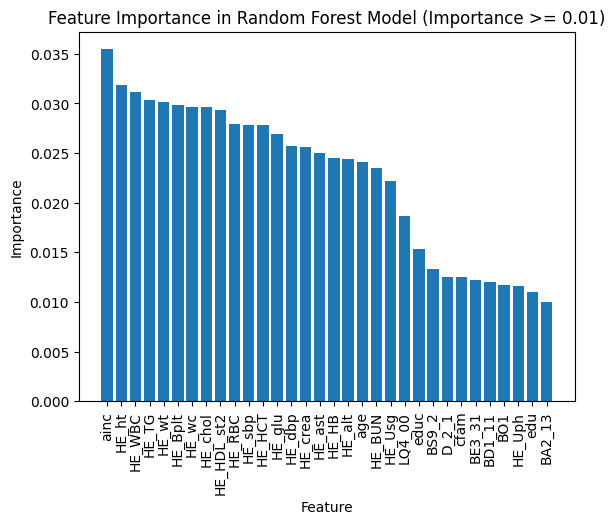

In [13]:
# 사용 모델
model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=2023)

model.fit(X_over, y_over)

# Feature 중요도 계산
feature_importances = model.feature_importances_

# 중요도가 0.01 이상인 feature만 선택
selected_features = X_over.columns[feature_importances >= 0.01]

# 중요도를 DataFrame으로 변환
rf_feature_importance_df = pd.DataFrame({
    'Feature': X_over.columns,
    'Importance': feature_importances
})

# Feature 중요도 시각화
selected_idx = np.argsort(feature_importances[feature_importances >= 0.01])[::-1]

plt.bar(range(len(selected_features)), feature_importances[feature_importances >= 0.01][selected_idx], align="center")
plt.xticks(range(len(selected_features)), selected_features[selected_idx], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance in Random Forest Model (Importance >= 0.01)")
plt.show()

In [14]:
rf_feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

,Feature,Importance
1,ainc,0.035448
4,HE_ht,0.031901
17,HE_WBC,0.031108
10,HE_TG,0.030362
5,HE_wt,0.030141
19,HE_Bplt,0.029868
6,HE_wc,0.029624
8,HE_chol,0.029598
9,HE_HDL_st2,0.029348
18,HE_RBC,0.027978


간단한 실험용 MLP를 이용해서 feature importance 구해보기

In [15]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance

X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)

ann_model = MLPClassifier(hidden_layer_sizes=(32,), 
                          max_iter=100, 
                          random_state=2023, 
                          solver='adam',
                          batch_size=32,
                          learning_rate='constant',)
ann_model.fit(X_train, y_train)

# permutation feature importance 계산
result = permutation_importance(ann_model, X_test, y_test, n_repeats=30, random_state=42)

# 중요도 및 관련 정보를 DataFrame으로 변환
feature_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance_Mean': result.importances_mean,
    'Importance_Std': result.importances_std
})

# 중요도를 기준으로 내림차순 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance_Mean', ascending=False)

# 결과 출력
feature_importance_df

# 결과 출력
# print("Permutation Feature Importance:")
# for i, imp in enumerate(result.importances_mean):
#     print(f"Feature {i}: {imp}")


,Feature,Importance_Mean,Importance_Std
73,ho_incm,0.001662,0.000423
1,ainc,0.001373,0.000499
22,sex,0.001295,0.000263
41,LQ4_00,0.000935,0.000228
27,D_2_1,0.000913,0.000279
...,...,...,...
59,HE_Uro,-0.000121,0.000096
46,EC_stt_2,-0.000130,0.000164
17,HE_WBC,-0.000159,0.000105
57,HE_Ubil,-0.000190,0.000103


In [16]:
feature_importance_df.head()

,Feature,Importance_Mean,Importance_Std
73,ho_incm,0.001662,0.000423
1,ainc,0.001373,0.000499
22,sex,0.001295,0.000263
41,LQ4_00,0.000935,0.000228
27,D_2_1,0.000913,0.000279


In [17]:
sort_importance = sorted(result.importances_mean,reverse=True)
sort_importance

[0.0016617462873501595,
 0.0013732331365181667,
 0.0012949543746645254,
 0.0009348720701377748,
 0.0009125067096081629,
 0.0009080336375022406,
 0.0009035605653963182,
 0.0008990874932903959,
 0.0008610663803900557,
 0.0008588298443370946,
 0.0008297548756485991,
 0.0007425299695831129,
 0.0007358203614242294,
 0.0006687242798353939,
 0.0006374127750939373,
 0.0005859724458758301,
 0.0005188763642869946,
 0.00046296296296296504,
 0.00044954374664519793,
 0.0004249418500626249,
 0.00042046877795670254,
 0.00040704956163893543,
 0.0003310073358382552,
 0.0003310073358382552,
 0.00030640543925568217,
 0.00030416890320272095,
 0.0002885131508319927,
 0.00028180354267310915,
 0.00026838432635534204,
 0.00025496511003757493,
 0.00025272857398461377,
 0.00022812667740204073,
 0.00021023438897835127,
 0.00018563249239577823,
 0.00018563249239577823,
 0.00017444981213097233,
 0.00016103059581320522,
 0.00015655752370728285,
 0.00015655752370728285,
 0.00015432098765432166,
 0.000147611379495438

### 결론
- Random Forest를 이용하여 학습시 영향 많이 주는 속성은 없음 아마 ANN에 사용한 feature를 그대로 사용하다 보니 이렇게 된것 같다
- Kfold를 사용할때 왜 score가 점점 증가하는지 이유를 모르겠습니다.


추가로 Heatmap 분석한 부분입니다.

train_X_df의 각 feature들의 상관관계를 분석하고 depressed와 얼마나 연관이 있는지 봅니다.

In [18]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20,15)})

In [19]:
df_new = X_over

## numerical features의 상관관계

- 사용 features

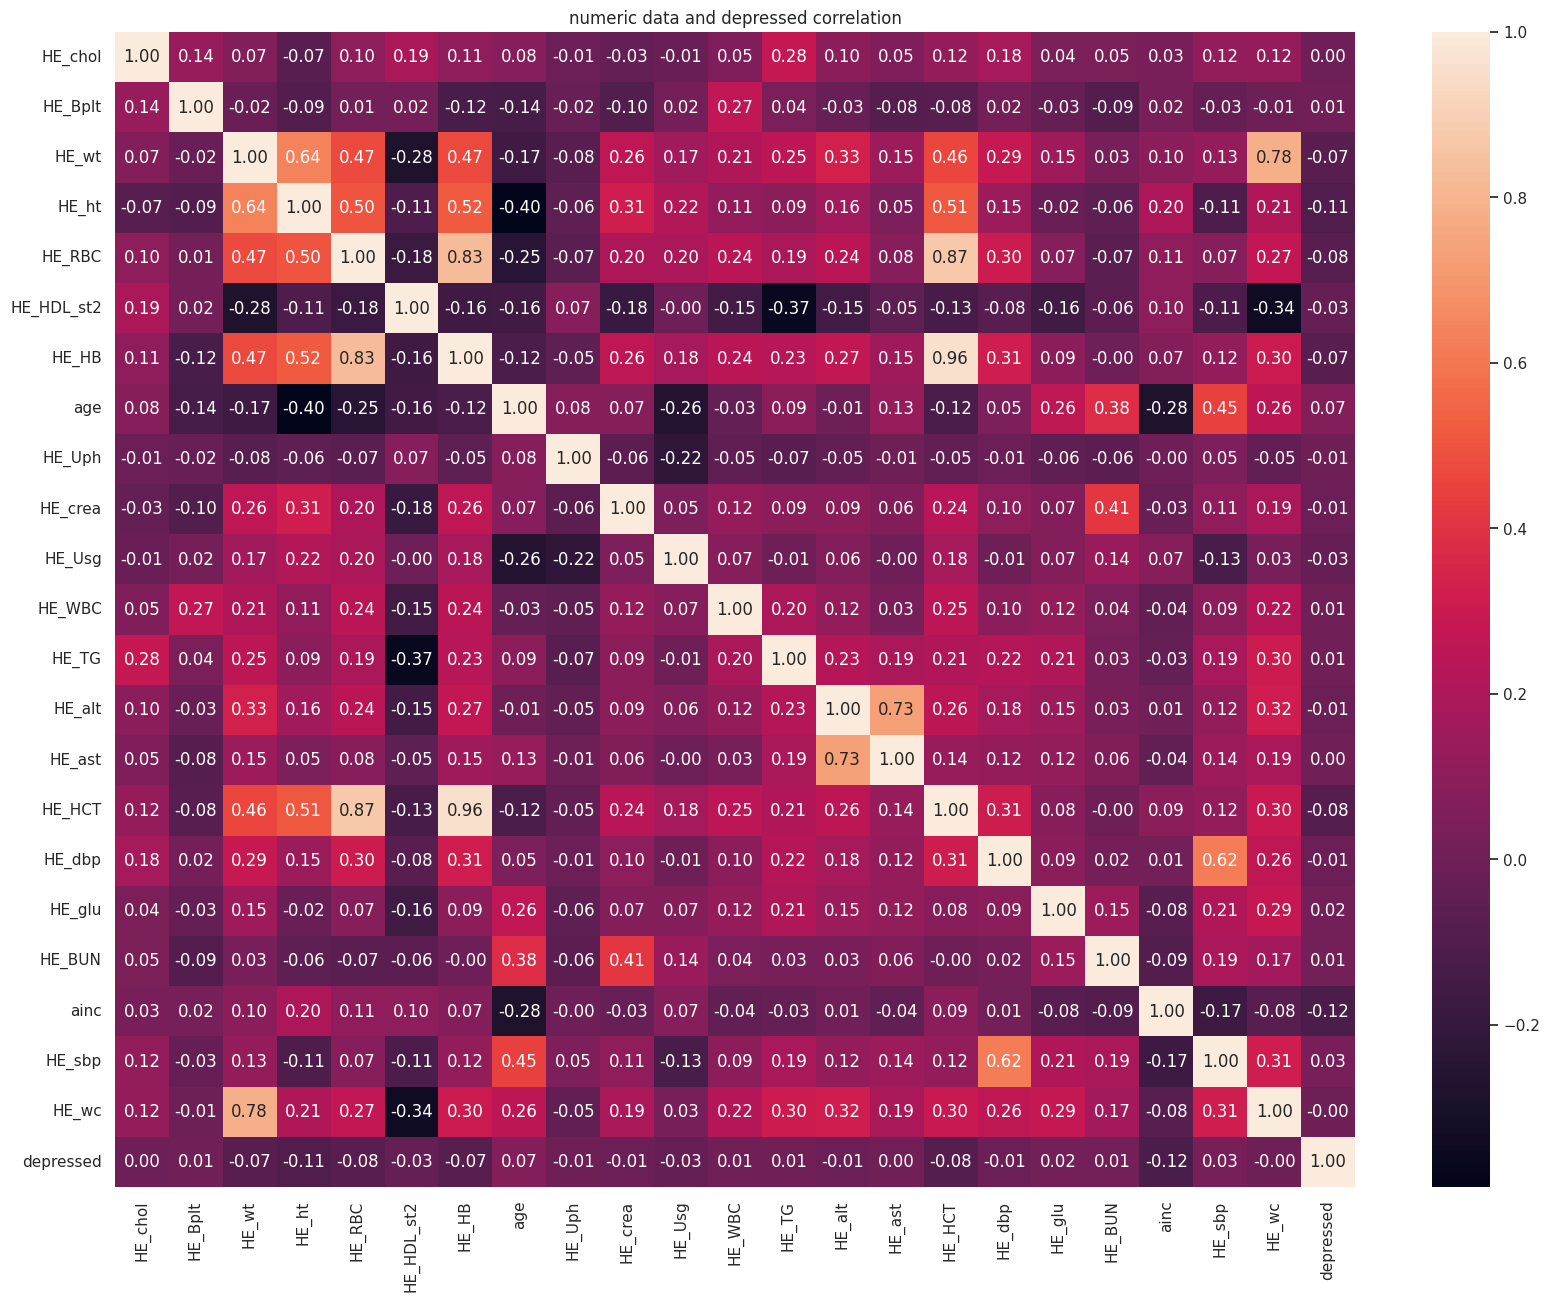

In [20]:
df_num = pd.concat([df_new[num_features],y_over], axis=1)
sns.heatmap(df_num.corr(), annot=True, fmt='.2f')
plt.title("numeric data and depressed correlation")
plt.show()

## label features의 상관관계

- 사용 features

In [21]:
df_label = pd.concat([df_new[label_features],y_over], axis=1)
sns.heatmap(df_label.corr(), annot=True, fmt='.2f')
plt.title("label data and depressed correlation")
plt.show()

KeyError: "['D_1_1'] not in index"

## OneHot Features의 상관관계

- 사용 features

In [ ]:
df_onehot = df_new.drop(num_features+label_features, axis=1)
df_onehot = pd.concat([df_onehot,y_over],axis=1)

- 상관관계가 0.15보다 높은 값만 선택합니다.

In [ ]:
correlation_matrix = df_onehot.corr()
threshold = 0.15

relevant_corr = correlation_matrix['depressed'][correlation_matrix['depressed'].abs() > threshold]

relevant_corr_matrix = df_onehot[relevant_corr.index].corr()

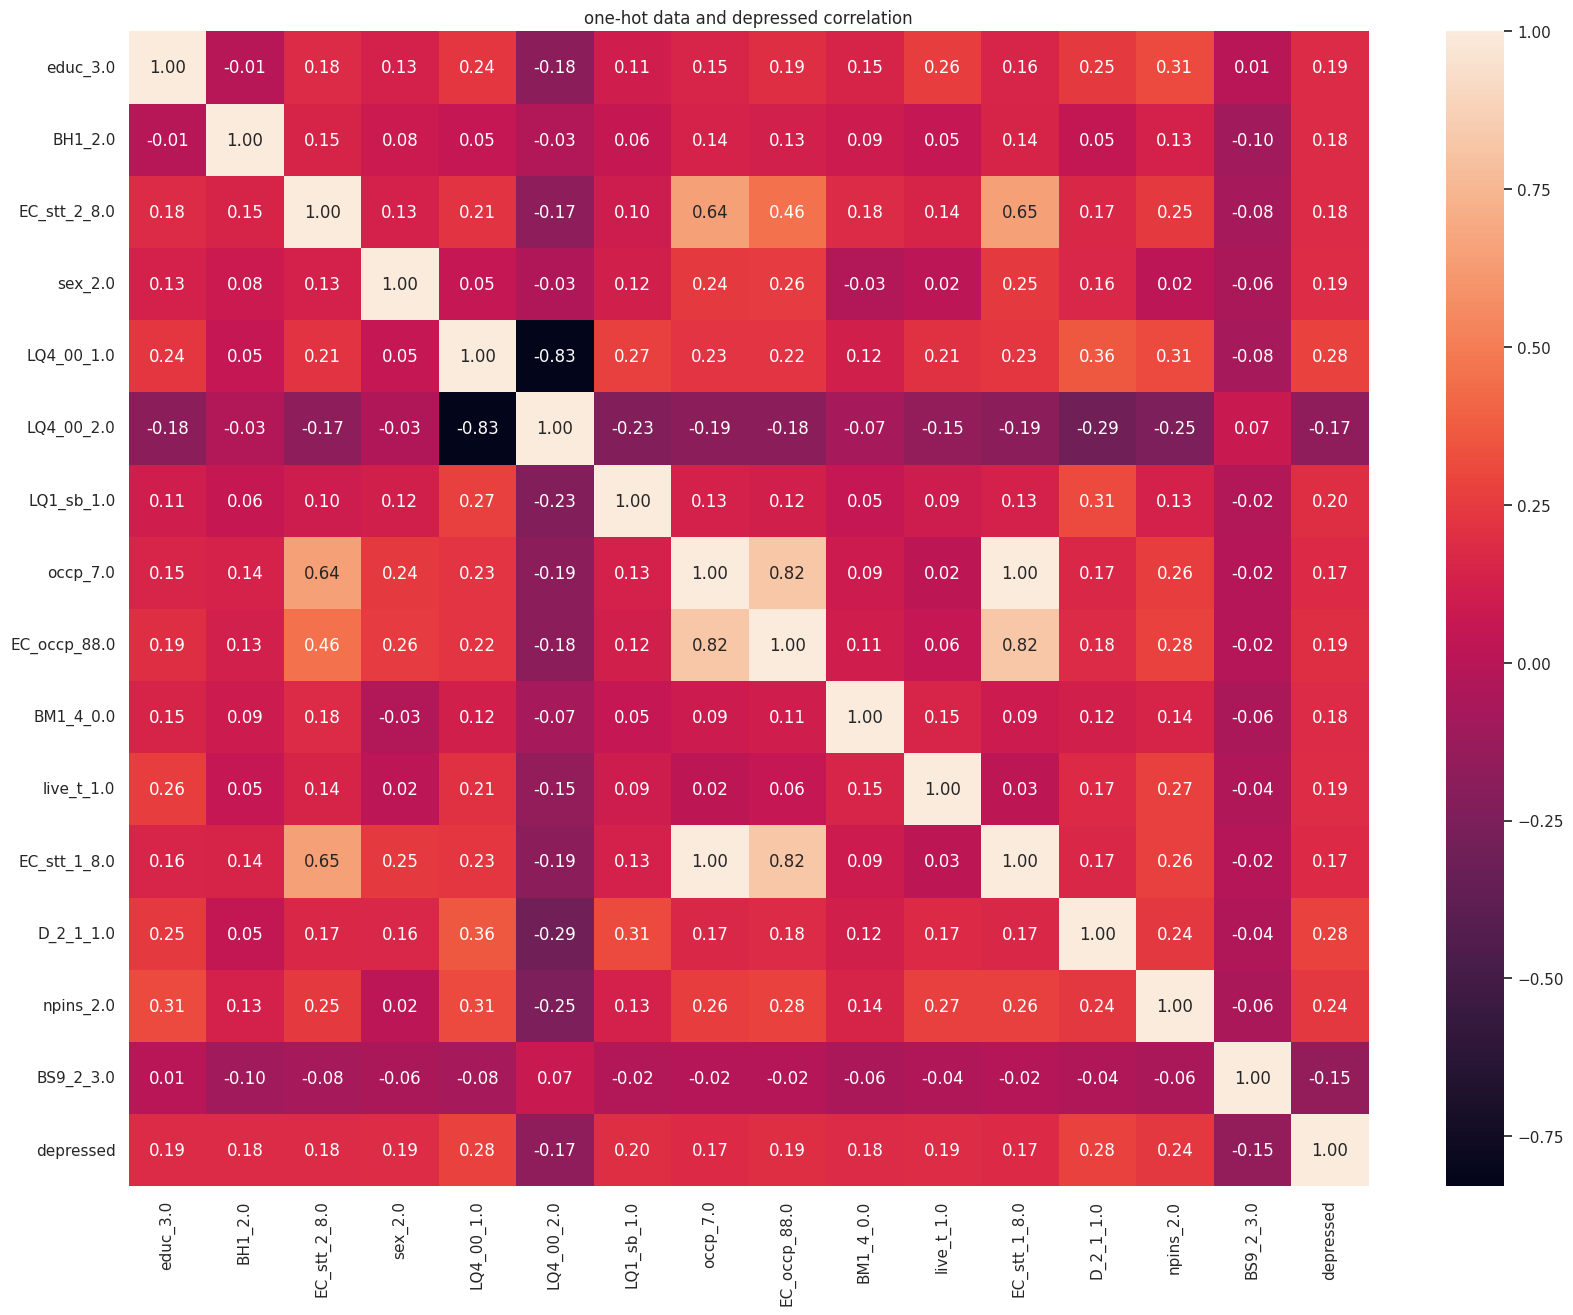

In [ ]:
# sns.set(rc={'figure.figsize':(25,20)})

sns.heatmap(relevant_corr_matrix, annot=True, fmt='.2f')
plt.title("one-hot data and depressed correlation")
plt.show()

depressed와 유의미하게 관계가 있는 features는 존재하지 않는것 같습니다. 따라서 머신러닝 모델에서는 성능이 그렇게 좋지는 않을 것으로 위 관계만 본다면 미리 예상 가능하고, 하지만 feature가 많은게 어떤 변수를 가져올지는 모르겠습니다.